# Song Classification with the GTZAN Dataset

In [116]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import imageio.v3
import librosa
import librosa.display

from tqdm import trange


In [97]:
genres = os.listdir('Data/genres_original/')

genre_dict = {genres[i]: i for i in range(len(genres))}
genre_dict

{'pop': 0,
 'metal': 1,
 'disco': 2,
 'blues': 3,
 'reggae': 4,
 'classical': 5,
 'rock': 6,
 'hiphop': 7,
 'country': 8,
 'jazz': 9}

In [21]:
three_sec_df = pd.read_csv('Data/features_3_sec.csv')

# changing dots in middle of file name to _ because it makes more sense
three_sec_df['filename'] = three_sec_df['filename'].apply(lambda x: f'{x[:-4].replace(".", "_")}.wav')

three_sec_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues_00000_0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues_00000_1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues_00000_2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues_00000_3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues_00000_4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock_00099_5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock_00099_6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock_00099_7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock_00099_8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [173]:
thirty_sec_df = pd.read_csv('Data/features_30_sec.csv')
thirty_sec_df['filename'] = thirty_sec_df['filename'].apply(lambda x: f'{x[:-4].replace(".", "_")}.wav')
thirty_sec_df = thirty_sec_df.drop([554]) # dropping entry that does not have spectrogram
thirty_sec_df


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues_00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues_00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues_00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues_00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues_00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock_00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock_00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock_00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock_00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [171]:
thirty_sec_df.loc[thirty_sec_df['filename'] == 'jazz_00054.wav']

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
554,jazz_00054.wav,662112,0.27827,0.083737,0.162394,0.002747,1670.233117,255560.9662,2109.438546,191916.069574,...,44.333191,-5.273277,56.501907,-1.605975,60.76976,-2.93224,52.397224,-1.418922,100.980064,jazz


In [23]:
# Removing the "." from the middle of file names and replacing with "_" in audio folders to match the spectrogram files and also because it's really stupid to put a . in the middle of a filename
# Run this only once because otherwise it won't work if you try it again, but probably won't break anything i guess
for genre in genres:
    for song_id in os.listdir(f'Data/genres_original/{genre}'):
        #print(song_id[:-4].replace(".", ""))
        os.rename(f'Data/genres_original/{genre}/{song_id}', f'Data/genres_original/{genre}/{song_id[:-4].replace(".", "_")}.wav')

In [157]:
class AudioDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        filename = self.data.iloc[idx]['filename']
        x, _ = librosa.load(filename)
        y = genre_dict[self.data.iloc[idx]['label']]

        return torch.Tensor(x), y
        

In [158]:
thirty_sec_df.iloc[0]['label']

'blues'

In [197]:
class SpectrogramDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        y = genre_dict[self.data.iloc[idx]['label']]
        #print(y)
        #print(genres[y])
        x = imageio.v3.imread(f'Data/images_original/{genres[y]}/{self.data.iloc[idx]["filename"][:-4].replace("_", "")}.png')
        
       
        #plt.imshow(x)
        return torch.Tensor(x), y


In [209]:
batch_size = 128

train_set, test_set = train_test_split(thirty_sec_df, test_size = 0.2)
#train_set, val_set = train_test_split(train_set, test_size = 0.2)

audio_train = AudioDataset(train_set)
#audio_val = AudioDataset(val_set)
audio_test = AudioDataset(test_set)

audio_train_dl = DataLoader(audio_train, batch_size=batch_size)
#audio_val_dl = DataLoader(audio_val, batch_size=batch_size)
audio_test_dl = DataLoader(audio_test, batch_size=batch_size)

spec_train = SpectrogramDataset(train_set)
#spec_val = SpectrogramDataset(val_set)
spec_test = SpectrogramDataset(test_set)

spec_train_dl = DataLoader(spec_train, shuffle=True, batch_size=batch_size)
#spec_val_dl = DataLoader(spec_val, shuffle=True, batch_size=batch_size)
spec_test_dl = DataLoader(spec_test, shuffle=True, batch_size=batch_size)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([288, 432, 4])
tensor([[[255., 255., 255., 255.],
         [255., 255., 255., 255.],
         [255., 255., 255., 255.],
         ...,
         [255., 255., 255., 255.],
         [255., 255., 255., 255.],
         [255., 255., 255., 255.]],

        [[255., 255., 255., 255.],
         [255., 255., 255., 255.],
         [255., 255., 255., 255.],
         ...,
         [255., 255., 255., 255.],
         [255., 255., 255., 255.],
         [255., 255., 255., 255.]],

        [[255., 255., 255., 255.],
         [255., 255., 255., 255.],
         [255., 255., 255., 255.],
         ...,
         [255., 255., 255., 255.],
         [255., 255., 255., 255.],
         [255., 255., 255., 255.]],

        ...,

        [[255., 255., 255., 255.],
         [255., 255., 255., 255.],
         [255., 255., 255., 255.],
         ...,
         [255., 255., 255., 255.],
         [255., 255., 255., 255.],
         [255., 255., 255., 255.]],

        [[255., 255., 255., 255.],
         [255., 255.,

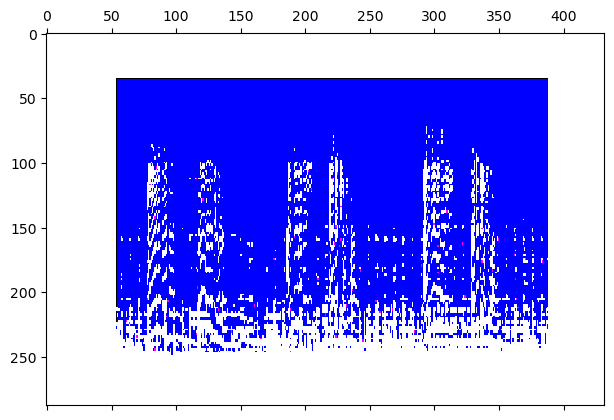

In [210]:
plt.matshow(spec_train[1][0])
print(spec_train[0][0].shape)
print(spec_train[0][0])

In [208]:
for i in range(50):
    print(spec_train[i][0].shape)

torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([288, 432, 4])
torch.Size([

that spectrogram looks awful but that's just some torch tensor garbage, the actual spectrograms are still good
matplotlib just doesn't like torch tensors

In [211]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


input_shape = (batch_size, 4, 288, 432)

class FeedforwardSpectrogramModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(4, 16, 3, stride=2)
        self.conv2 = nn.Conv2d(16, 16, 3, stride=2)
        self.dropout1 = nn.Dropout()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU(True)

        self.conv3 = nn.Conv2d(16, 32, 3, stride=2)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2)
        self.dropout2 = nn.Dropout()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.ReLU(True)

        self.conv5 = nn.Conv2d(16, 32, 3, stride=2)
        self.conv6 = nn.Conv2d(32, 32, 3, stride=2)
        self.dropout3 = nn.Dropout()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.relu3 = nn.ReLU(True)

        self.dense = nn.Linear(32 * 3 * 3, 10)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        print('before first conv block')
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout1(x)
        x = self.pool1(x)
        x = self.relu1(x)

        print('before second conv block')
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dropout2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        
        print('before third conv block')
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.dropout(x)
        x = self.pool3(x)
        x = self.relu3(x)

        x = self.dense(x)
        out = self.sigmoid(x)

        return out

model = FeedforwardSpectrogramModel().to(DEVICE)

In [212]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []

    for i, (img, label) in enumerate(train_loader):
        #print(img)
        #print(img.shape)
        #print(label)
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(img)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, label)
        loss.backward()

        optimizer.step()

        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))
    
    return losses, counter

def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            # ------------------
            # Write your implementation here.
            
            output = model(img)

            pred = output.data.max(1, keepdim=True)[1] # Get index of largest log-probability and use that as prediction
            num_correct += pred.eq(label.data.view_as(pred)).sum()
            criterion = nn.CrossEntropyLoss()
            test_loss += criterion(output, label)

            # ------------------
            
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

In [213]:
train_loader = spec_train_dl
test_loader = spec_test_dl

# Hyperparameters
lr = 0.001
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []
test_losses = []
test_correct = []
for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)

print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")

Epochs:   0%|          | 0/10 [00:01<?, ?it/s]

before first conv block


RuntimeError: Given groups=1, weight of size [16, 4, 3, 3], expected input[128, 288, 432, 4] to have 4 channels, but got 288 channels instead